<a href="https://colab.research.google.com/github/abhiraman/Capstone_Project/blob/main/Image_to_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

REFERENCES:

https://towardsdatascience.com/a-gentle-introduction-to-ocr-ee1469a201aa
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html



# Importing Dependencies

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import cv2
import os
import matplotlib.pyplot as plt
import random
import numpy as np
from matplotlib import font_manager
import time
from  torch.utils.data import Dataset,DataLoader 
import pandas as pd
from torchvision import transforms
from skimage import io

Mounting Drive

In [5]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [6]:
%cd /gdrive/MyDrive/Capstone_project_data/ImgtoText

/gdrive/MyDrive/Capstone_project_data/ImgtoText


In [7]:
!ls

Cropped_Images	TrainImages.zip


In [ ]:
!unzip TrainImages.zip

# Data Loader 

In [9]:
## All Hindi Alphabets ## 
all_hindi_alpha = [chr(i) for i in range(2304,2432)]
all_hindi_alpha = {all_hindi_alpha[i]:i+1 for i in range(len(all_hindi_alpha))}
all_hindi_alpha[" "] = len(all_hindi_alpha)+1
print(all_hindi_alpha)
print(len(all_hindi_alpha))

{'ऀ': 1, 'ँ': 2, 'ं': 3, 'ः': 4, 'ऄ': 5, 'अ': 6, 'आ': 7, 'इ': 8, 'ई': 9, 'उ': 10, 'ऊ': 11, 'ऋ': 12, 'ऌ': 13, 'ऍ': 14, 'ऎ': 15, 'ए': 16, 'ऐ': 17, 'ऑ': 18, 'ऒ': 19, 'ओ': 20, 'औ': 21, 'क': 22, 'ख': 23, 'ग': 24, 'घ': 25, 'ङ': 26, 'च': 27, 'छ': 28, 'ज': 29, 'झ': 30, 'ञ': 31, 'ट': 32, 'ठ': 33, 'ड': 34, 'ढ': 35, 'ण': 36, 'त': 37, 'थ': 38, 'द': 39, 'ध': 40, 'न': 41, 'ऩ': 42, 'प': 43, 'फ': 44, 'ब': 45, 'भ': 46, 'म': 47, 'य': 48, 'र': 49, 'ऱ': 50, 'ल': 51, 'ळ': 52, 'ऴ': 53, 'व': 54, 'श': 55, 'ष': 56, 'स': 57, 'ह': 58, 'ऺ': 59, 'ऻ': 60, '़': 61, 'ऽ': 62, 'ा': 63, 'ि': 64, 'ी': 65, 'ु': 66, 'ू': 67, 'ृ': 68, 'ॄ': 69, 'ॅ': 70, 'ॆ': 71, 'े': 72, 'ै': 73, 'ॉ': 74, 'ॊ': 75, 'ो': 76, 'ौ': 77, '्': 78, 'ॎ': 79, 'ॏ': 80, 'ॐ': 81, '॑': 82, '॒': 83, '॓': 84, '॔': 85, 'ॕ': 86, 'ॖ': 87, 'ॗ': 88, 'क़': 89, 'ख़': 90, 'ग़': 91, 'ज़': 92, 'ड़': 93, 'ढ़': 94, 'फ़': 95, 'य़': 96, 'ॠ': 97, 'ॡ': 98, 'ॢ': 99, 'ॣ': 100, '।': 101, '॥': 102, '०': 103, '१': 104, '२': 105, '३': 106, '४': 107, '५': 108, '६': 109, '७': 110, '८': 11

In [12]:
annots_file = os.listdir("./Annotations")
with open("./Annotations/"+str(annots_file[0])) as fh:
  allLineList = fh.readlines()
fh.close()
labelGenerator = (allLineList[i].split('\t')[-1].strip('\n') for i in range(0,len(allLineList)-1))
labelGenerator = list(labelGenerator)

In [13]:
print(labelGenerator)

['चले', 'आए', 'वह', 'कोई', 'वह', 'कह', 'वह', 'पर', 'पर', 'अब', 'न', 'यह', 'एक', 'कर', 'रहा', 'पर', 'लगी', 'अपने', 'ऐसा', 'दस', 'गई', 'बैठ', 'चाय', 'चुप', 'लगा', 'और', 'गए', 'समूह', 'पर', 'तक', 'वह', 'आये', 'रचा', 'और', 'रंग', 'फिर', 'भुन', 'लिए', 'बन', 'पर', 'एक', 'यह', 'घर', 'नई', 'और', 'कहा', 'एवं', 'करो', 'और', 'जब', 'पर', 'बीच', 'तक', 'बहुत', 'गए', 'और', 'और', 'झूठ', 'दिन', 'उसे', 'रहा', 'तुम', 'रह', 'तरह', 'वह', 'पर', 'पर', 'चुन', 'बात', 'गया', 'पर', 'जब', 'चल', 'समय', 'पर', 'वह', 'वह', 'से', 'और', 'तेल', 'करो', 'करने', 'और', 'इस', 'निकल', 'रहा', 'एक', 'पर', 'पर', 'पर', 'सब', 'खैर', 'रही', 'हर', 'वह', 'तुम', 'करता', 'देखकर', 'करके', 'हरी', 'पर', 'पर', 'अभी', 'तक', 'आई', 'पर', 'सर', 'अन्य', 'पर', 'कर', 'यह', 'पर', 'बढ़', 'यह', 'कोई', 'बहुत', 'लिए', 'गई', 'और', 'चुनकर', 'धत्', 'अब', 'शौच', 'बूझ', 'बजे', 'एक', 'पर', 'हर', 'और', 'और', 'यह', 'लगे', 'ऐसा', 'मन', 'बीच', 'गई', 'रहा', 'एक', 'अंक', 'कर', 'उन', 'जज', 'उस', 'वह', 'उस', 'रह', 'कई', 'एक', 'दराज', 'अब', 'कब', 'नाम', 'तब', 'यह', 

Encode Hindi Words

In [14]:
def gt_rep(word, letter2index,max_str_len = None, device = 'cpu'):
  gt_rep = torch.zeros([max_str_len, 1], dtype=torch.long).to(device)
  if len(word)<max_str_len:
    diff = max_str_len-len(word)
    word = ''.join((word," "*diff))
  for letter_index, letter in enumerate(word):
    pos = letter2index[letter]
    gt_rep[letter_index][0] = pos
  return gt_rep

In [26]:
class MyCollateClass:
  def __init__(self,dim=1):
    self.dim = dim

  def stackTensors(self,itera):
    return torch.stack(itera['image'])

  def padTensor(self,Tensor,maxStrLen):
    Tensor = Tensor.view(Tensor.shape[0],)
    if Tensor.shape[0] == maxStrLen:return Tensor
    else:
      diff = maxStrLen - Tensor.shape[0]
      return torch.cat([Tensor,torch.zeros(diff)],dim=0)


  def PadCollate(self,batch):
    finalDict = {}
    Imglabel_list = list(((eDict['image'],eDict['label']) for eDict in batch))
    ImgTensorList,LabelList = list(zip(*Imglabel_list))
    #print(len(ImgTensorList),len(LabelList))
    seqlenList = list((len(eTensor) for eTensor in LabelList))
    maxStrLen = max(seqlenList)
    #print(LabelList[0].shape)
    paddedLabelList = list((self.padTensor(e_tensor,maxStrLen) for e_tensor in LabelList))
    ImgTensor,LabelTensor = torch.stack(ImgTensorList),torch.stack(paddedLabelList)
    finalDict = {"Images":ImgTensor,"Label":LabelTensor}
    #print(ImgTensor.shape,LabelTensor.shape)
    return finalDict

  
  def __call__(self,batch):
    return self.PadCollate(batch)


In [28]:
class HindiTextDataset(Dataset):
  def __init__(self,LabelList = None,RootDirectory = None,transform=None):
    self.LabelList = LabelList
    print("iter")
    self.root_dir = RootDirectory
    self._get_max_str_len()
    self.transform = transform

  def __len__(self):
    return len(self.LabelList)
  
  def _get_max_str_len(self):
    temp = []
    for e_str in self.LabelList:
      counter = 0
      for e_char in e_str:counter+=1
      temp.append(counter)
    self.max_str_len = max(temp)

  
  def __getitem__(self,idx):
    #img_tensor = torch.tensor(io.imread(''.join([self.root_dir,str(idx),'.jpg'])),dtype = torch.float32)
    img_tensor = io.imread(''.join([self.root_dir,str(idx),'.jpg']))
    img_tensor = self.transform(img_tensor)
    #torch.tensor(preprocessing.minmax_scale(img_tensor),dtype=torch.float32)
    label_tensor = gt_rep(self.LabelList[idx],all_hindi_alpha,max_str_len = self.max_str_len)
    #print("label tensor computed")
    sample = {'image':img_tensor,'label':label_tensor}
    return sample

In [21]:
transform_batch = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
    

In [29]:
TextDataset = HindiTextDataset(labelGenerator,"./TrainImages/",transform = transform_batch)


iter


In [30]:
for i in range(len(TextDataset)):
  print("Image Size : ",TextDataset[i]["image"].shape,"Label Size : ",TextDataset[i]["label"].shape)
  if i==3:
    break

Image Size :  torch.Size([3, 128, 128]) Label Size :  torch.Size([12, 1])
Image Size :  torch.Size([3, 128, 128]) Label Size :  torch.Size([12, 1])
Image Size :  torch.Size([3, 128, 128]) Label Size :  torch.Size([12, 1])
Image Size :  torch.Size([3, 128, 128]) Label Size :  torch.Size([12, 1])


Custom Dataset Loader 

In [31]:
batch_size = 4
dataloader1 = DataLoader(TextDataset, batch_size=batch_size,
                        shuffle=True, num_workers=0)

Show Sample Data

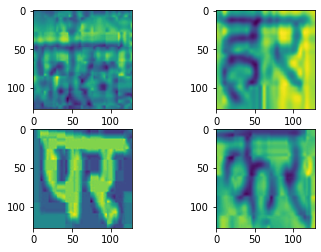

In [44]:
for ind,data in enumerate(dataloader1):
  if ind>0:break
  fig = plt.figure()
  nrows,ncols = batch_size//2,batch_size//2
  ax = fig.subplots(nrows,ncols)
  counter = 0
  for i in range(nrows):
    for j in range(ncols):
      ax[i,j].imshow(data['image'][counter][0])
      counter+=1



# ENCODER PART

In [2]:
class FeatureExtractor(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(3,64,3), ## (N,3,128,128) -> (N,64,124,124)
        nn.ReLU(),
        nn.AvgPool2d(2,2), ## (N,64,62,62)
        nn.Conv2d(64,256,3), ## (N,64,62,62) -> (N,256,60,60)
        nn.ReLU(),
        nn.AvgPool2d(2,2), ## (N,256,30,30)
        nn.Conv2d(256,512,3)
    )
    self.decoder = nn.LSTM(input_size,hidden_size,batch_first=True)
    self.h2o = nn.Linear(hidden_size,output_size)


  def forward(self,x):
    ff_pass = self.encoder(x)

    return ff_pass

# DECODER PART

In [ ]:
## Extracted feature from CNN will act as input for Encoder-Decoder Model , each column x channel Depth on an input for the encoder-decoder model ## 
class LSTM_Net(nn.Module):
  def __init__(self,input_size=None,hidden_size=None,output_size=None,batch_size=None):
    self.hidden_size = hidden_size
    self.batch_size = batch_size
    super().__init__()
    self.hidden_size = hidden_size
    self.lstm_cell = nn.LSTM(input_size,hidden_size)
    self.h2o = nn.Linear(hidden_size,output_size)
   

  def forward(self,input,hidden):
    print(input.shape)
    print(hidden[0].shape)
    out,hidden = self.lstm_cell(input,hidden)
    output = self.h2o(out)
    output = nn.functional.log_softmax(output,dim=2)
    return output,hidden
  
  def init_hiddenlayer(self):
    return (torch.zeros(1,self.batch_size,self.hidden_size),torch.zeros(1,self.batch_size,self.hidden_size))


In [ ]:
hidden_size = 128
def batchTrain(TextDataSet,EncoderModel=None,batchSize=None,lr=0.0005):
  loadedData = DataLoader(TextDataset,batch_size=batch_size,shuffle=True)

  for ind,data in enumerate(loadedData):
    img_tensor = data['image'].permute(0,3,1,2)
    img_tensor = torch.tensor(img_tensor,dtype=torch.float32)
    print(img_tensor.shape)
    #img_tensor = torch.reshape(img_,(,img_.shape[0],img_.shape[1],img_.shape[2]))
    encoder_fpass = EncoderModel(img_tensor)
    encoder_fpass_new = encoder_fpass.view(encoder_fpass.shape[0],encoder_fpass.shape[1]*encoder_fpass.shape[2],encoder_fpass.shape[3]).permute(1,0,2)
    print(encoder_fpass_new.shape)
    decoder_obj = LSTM_Net(encoder_fpass_new.shape[0],hidden_size,len(all_hindi_alpha),batch_size)
    hidden = decoder_obj.init_hiddenlayer()
    print(hidden[0].shape,hidden[1].shape)
    output,hidden = decoder_obj.forward(encoder_fpass_new.permute(2,1,0),hidden)
    ctc_loss = nn.CTCLoss()
    input_lengths = torch.Tensor([output.size(1)] * 1).int()
    print(input_lengths)
    target_lengths = torch.tensor(trainGenerator[1][i].shape[0])
    print(target_lengths)
    print(trainGenerator[1][i])
    print(trainGenerator[1][i].view(-1))
    # 0/0
    loss =  ctc_loss(output.permute(1,0,2),trainGenerator[1][i],input_lengths,target_lengths)
    print(loss)
    0/0
  # indexs = torch.argmax(output,dim=-1)
  # predicted_alphas = [all_hindi_alpha[e_indx] for e_indx in indexs]
  # print(predicted_alphas)


In [ ]:
## hYPERPARAMERS
batchSize = 500
num_layers = 1
num_dirn = 1

EncodeModel = FeatureExtractor()
LSTM_Net()



In [ ]:
batchTrain(TextDataset,extractor_obj,4)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


torch.Size([4, 3, 128, 128])
torch.Size([4, 512, 28, 28])
torch.Size([14336, 4, 28])
torch.Size([1, 4, 128]) torch.Size([1, 4, 128])
torch.Size([28, 4, 14336])
torch.Size([1, 4, 128])
torch.Size([1, 4, 129])


ZeroDivisionError: ignored